In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from nltk.corpus import stopwords
import gensim
import xgboost, textblob, string
import re
import nltk
import string
import spacy
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
df = pd.read_csv('tripadvisor.csv', index_col='date', parse_dates=True)
df['title'] = df['title'].astype(str)
df.head()

,title,review,rating,label
date,,,,
2019-10-22,"great guide, colosseum was a little underwhelming",our guide serena was great and informative. ou...,4,1
2019-10-21,night tour of colosseum and underground,serena was an exceptional guide for this tour....,5,1
2019-10-21,versailles & louvre tours,both were amazing. their staff is very knowled...,5,1
2019-10-21,superb!,"sara was entertaining, responsive and knowledg...",5,1
2019-10-21,tour of a lifetime,this tour was fascinating and very well ran. t...,5,1


In [3]:
def check_sent(search_list, df):
    count = 0
    for w in search_list:
        l = df[df['review'].str.contains(w, na=False)].shape[0]
        count += l
    print(count)
    print(count/df.shape[0])

Text(0.5, 1.0, 'review amounts')

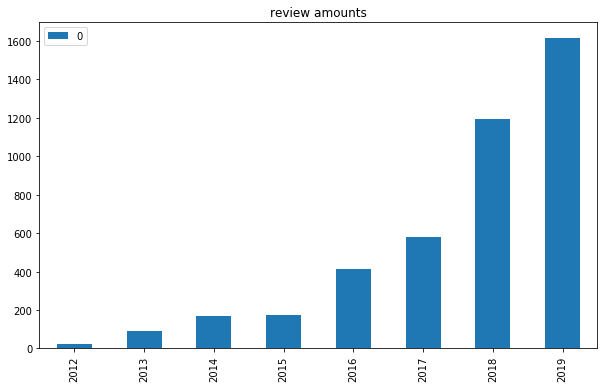

In [4]:
# split negative reviews
pos = df[df['label']==1]
neg = df[df['label']==0]

rv_count = []
years = []
for i in range(12, 20, 1):
    year = '20{}'.format(i)
    years.append(year)
    rv_amt = df[year].shape[0]
    rv_count.append(rv_amt)


tbl = pd.DataFrame(rv_count, years)
tbl.plot(kind='bar', figsize=(10,6))
plt.title('review amounts')

Text(0.5, 1.0, 'percentage of negative reviews')

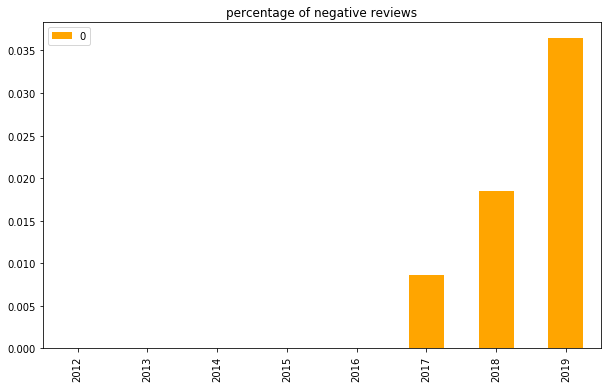

In [5]:
neg_count = []
years = []
for i in range(12, 20, 1):
    year = '20{}'.format(i)
    years.append(year)
    neg_amt = neg[year].shape[0]
    rv_amt = df[year].shape[0]
    pct = neg_amt/rv_amt
    neg_count.append(pct)
    
tbl = pd.DataFrame(neg_count, years)
tbl.plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('percentage of negative reviews')

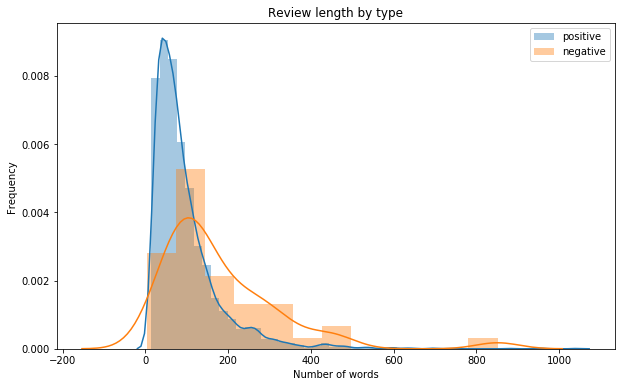

In [6]:
df["length"] = df["review"].apply(lambda x: len(x.split()))
pos = df[df['label']==1]
neg = df[df['label']==0]
plt.figure(figsize = (10, 6))
sns.distplot(pos["length"], hist = True, label = "positive")
sns.distplot(neg["length"], hist = True, label = "negative")
plt.legend(fontsize = 10)
plt.title("Review length by type", fontsize = 12)
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

In [7]:
# remove stop words
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english') 
stop_words.extend(['tour', 'tours', 'guide', 'roman', 'guy', 'us', 'can', 'could', 'would', 'should', 'might', "won't", 
                   'was', 'must', 'is', "hasn't", "aren't", "are", "ain't", "isn't", 'recommend', 'review'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bichn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# tokenize and clean
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuation

data_words = list(sent_to_words(neg['review']))
print(data_words[:1])

[['this', 'tour', 'was', 'exhausting', 'we', 'met', 'at', 'and', 'didn', 'enter', 'until', 'after', 'this', 'is', 'lot', 'of', 'standing', 'around', 'before', 'the', 'tour', 'even', 'starts', 'the', 'tour', 'was', 'supposed', 'to', 'head', 'straight', 'to', 'the', 'sistine', 'chapel', 'but', 'instead', 'we', 'made', 'many', 'stops', 'along', 'the', 'way', 'with', 'explanations', 'the', 'sistine', 'chapel', 'was', 'relatively', 'uncrowded', 'which', 'was', 'nice', 'to', 'this', 'point', 'the', 'tour', 'was', 'enjoyable', 'the', 'problem', 'was', 'we', 'then', 'went', 'and', 'rewalked', 'the', 'same', 'tour', 'at', 'this', 'point', 'there', 'were', 'massive', 'crowds', 'with', 'people', 'pressed', 'together', 'squeezing', 'through', 'small', 'doorways', 'we', 'saw', 'the', 'same', 'galleries', 'again', 'only', 'in', 'much', 'more', 'crowded', 'situation', 'we', 'saw', 'the', 'sistine', 'chapel', 'again', 'but', 'with', 'masses', 'of', 'people', 'pushing', 'to', 'try', 'to', 'exit', 'one'

In [9]:
# Bigram and trigram models 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  
 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(bigram_mod[data_words[0]])

['this', 'tour', 'was', 'exhausting', 'we', 'met', 'at', 'and', 'didn', 'enter', 'until', 'after', 'this', 'is', 'lot', 'of', 'standing', 'around', 'before', 'the', 'tour', 'even', 'starts', 'the', 'tour', 'was', 'supposed', 'to', 'head', 'straight', 'to', 'the', 'sistine_chapel', 'but', 'instead', 'we', 'made', 'many', 'stops', 'along', 'the', 'way', 'with', 'explanations', 'the', 'sistine_chapel', 'was', 'relatively', 'uncrowded', 'which', 'was', 'nice', 'to', 'this', 'point', 'the', 'tour', 'was', 'enjoyable', 'the', 'problem', 'was', 'we', 'then', 'went', 'and', 'rewalked', 'the', 'same', 'tour', 'at', 'this', 'point', 'there', 'were', 'massive', 'crowds', 'with', 'people', 'pressed', 'together', 'squeezing', 'through', 'small', 'doorways', 'we', 'saw', 'the', 'same', 'galleries', 'again', 'only', 'in', 'much', 'more', 'crowded', 'situation', 'we', 'saw', 'the', 'sistine_chapel', 'again', 'but', 'with', 'masses', 'of', 'people', 'pushing', 'to', 'try', 'to', 'exit', 'one', 'couple'

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
!pip install -U spacy download en_core_web_sm

Requirement already up-to-date: spacy in c:\users\bichn\appdata\local\continuum\anaconda3\lib\site-packages (2.2.3)
Requirement already up-to-date: download in c:\users\bichn\appdata\local\continuum\anaconda3\lib\site-packages (0.3.4)
Requirement already up-to-date: en_core_web_sm in c:\users\bichn\appdata\local\continuum\anaconda3\lib\site-packages (2.2.5)


In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)


# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm')

# Do lemmatization keeping only noun, adj
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])

print(data_lemmatized[:1])

[['lot', 'start', 'head', 'many', 'stop', 'way', 'explanation', 'uncrowded', 'nice', 'point', 'enjoyable', 'problem', 'point', 'massive', 'crowd', 'people', 'small', 'doorway', 'gallery', 'crowded', 'situation', 'people', 'couple', 'group', 'claustrophobic', 'drop', 'time', 'basilica', 'exhausted', 'poor', 'planning', 'part', 'operator', 'money', 'goal', 'many', 'people', 'museum', 'possible', 'good', 'visitor', 'minimal', 'many', 'people', 'time', 'dangerous', 'thing', 'wrong', 'people', 'fire', 'life', 'emergency', 'exit', 'visible', 'people', 'money', 'power']]


text_neg = []
for i in data_lemmatized:
    for j in i: 
        text_neg.append(j)

cleanwords = [i for i in text_neg if i not in stop_words and i.isalpha()]
print(cleanwords[:10])

# prep the wordcloud
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000).generate(" ".join(cleanwords))

# plot
fig_custom = plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 6), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)]]


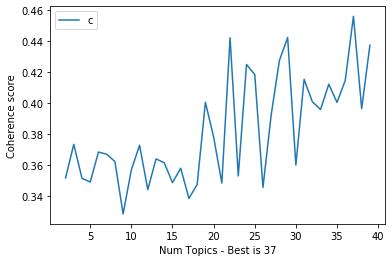

In [14]:
# Find the best # of topics 
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=1)

# Show graph
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
optimal_x = x[coherence_values.index(max(coherence_values))]
plt.xlabel("Num Topics - Best is {}".format(optimal_x))
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=32, 
                                           random_state=2,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
#doc_lda = lda_model[corpus]

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.929990345840662

Coherence Score:  0.42736593188499883


In [18]:
# Mallet
#os.environ.update({'MALLET_HOME':'C:\\Users\\bichn\\Desktop\\Files\\MSBA\\0B TTG\\mallet-2.0.8\\mallet-2.0.8'})
#mallet_path = 'C:\\Users\\bichn\\Desktop\\Files\\MSBA\\0B TTG\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet'
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [19]:
# Visualize the topics
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=38, 
                                           random_state=2,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


# Visualize
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -6.962141238808555

Coherence Score:  0.4770732569702988


C:\Users\bichn\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.208287 -0.063620       1        1  10.562298
6      0.182110 -0.012793       2        1   9.838510
23     0.119884  0.010765       3        1   7.858965
33     0.135281  0.052649       4        1   5.745051
7      0.131368 -0.055275       5        1   4.905212
1      0.097513  0.089291       6        1   4.810858
18     0.072508  0.142509       7        1   4.735739
25     0.086642  0.109188       8        1   3.954523
30     0.133305 -0.108161       9        1   3.676100
13     0.031302  0.112625      10        1   3.548368
4      0.028274 -0.008910      11        1   3.539979
14     0.046370  0.082579      12        1   3.322918
20    -0.047785  0.018998      13        1   2.551822
15     0.023350 -0.088828      14        1   2.412088
10     0.049283 -0.090243      15        1   2.339515
12     0.092882 -0.096734      16        1   2.144037
29     0.008913  0.027878      17        1   2.113265
5     -0.132707 -0.074471      18        1   2.093077
3     -0.044173  0.076483      19        1   1.995207
16     0.094949 -0.093735      20        1   1.977009
35    -0.074514  0.119636      21        1   1.792200
27    -0.062049 -0.056096      22        1   1.706111
21    -0.072308  0.121412      23        1   1.600530
34    -0.054578  0.047527      24        1   1.599470
37    -0.045122 -0.021413      25        1   1.501863
8     -0.043183  0.052820      26        1   1.333556
28    -0.155229 -0.031236      27        1   1.276704
22    -0.131671 -0.087189      28        1   1.256759
31    -0.033402  0.051718      29        1   0.872985
0     -0.087823  0.050769      30        1   0.860750
32    -0.000092 -0.041009      31        1   0.860354
19    -0.093391 -0.069375      32        1   0.571664
36    -0.066629 -0.003626      33        1   0.410976
24    -0.075093 -0.030391      34        1   0.047284
17    -0.076897 -0.034147      35        1   0.046805
9     -0.082272 -0.033323      36        1   0.045966
2     -0.081585 -0.032898      37        1   0.045958
26    -0.081718 -0.033375      38        1   0.045517, topic_info=    Category       Freq       Term      Total  loglift  logprob
84   Default  46.000000       line  46.000000  30.0000  30.0000
250  Default  33.000000    company  33.000000  29.0000  29.0000
106  Default  38.000000       hour  38.000000  28.0000  28.0000
41   Default  72.000000       time  72.000000  27.0000  27.0000
55   Default  37.000000  colosseum  37.000000  26.0000  26.0000
..       ...        ...        ...        ...      ...      ...
306  Topic38   0.001467       wife   3.022082   0.0646  -6.8732
305  Topic38   0.001467      watch   2.368163   0.3084  -6.8732
304  Topic38   0.001467      waste   5.729974  -0.5752  -6.8732
303  Topic38   0.001467     visual   1.458183   0.7933  -6.8732
330  Topic38   0.001467   scramble   1.438774   0.8067  -6.8732

[1898 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
567      17  0.479204  ability
149       3  0.105991     able
149       4  0.211982     able
149       5  0.105991     able
149       6  0.211982     able
...     ...       ...      ...
96       23  0.184183     year
459       1  0.762460    young
459       2  0.190615    young
530       7  0.438554  youtube
530      11  0.438554  youtube

[1971 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 7, 24, 34, 8, 2, 19, 26, 31, 14, 5, 15, 21, 16, 11, 13, 30, 6, 4, 17, 36, 28, 22, 35, 38, 9, 29, 23, 32, 1, 33, 20, 37, 25, 18, 10, 3, 27])

In [20]:
# Visualize the topics
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=2,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


# Visualize
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -6.793623651737346

Coherence Score:  0.4435921619259192


C:\Users\bichn\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.164801 -0.060668       1        1  19.011393
7     -0.102068  0.100649       2        1  12.886564
1     -0.068667 -0.009105       3        1   9.993402
14    -0.079195  0.157849       4        1   7.652444
11    -0.125385 -0.033125       5        1   6.588749
4     -0.042001  0.025514       6        1   6.391756
13    -0.078991 -0.081728       7        1   5.851902
12    -0.068093 -0.094157       8        1   5.246060
18     0.013896  0.158526       9        1   4.475641
0     -0.047461  0.043588      10        1   3.899992
16    -0.004313 -0.116897      11        1   3.487265
8      0.001376  0.051155      12        1   2.506789
19     0.133730  0.006287      13        1   2.056664
15     0.049305 -0.064234      14        1   1.940424
10     0.111347 -0.021416      15        1   1.876828
5      0.136974  0.089487      16        1   1.861947
9      0.053049 -0.050994      17        1   1.828097
3      0.090548 -0.077470      18        1   1.691648
2      0.106646 -0.016739      19        1   0.688688
17     0.084104 -0.006522      20        1   0.063747, topic_info=    Category       Freq       Term      Total  loglift  logprob
84   Default  44.000000       line  44.000000  30.0000  30.0000
106  Default  37.000000       hour  37.000000  29.0000  29.0000
160  Default  14.000000    headset  14.000000  28.0000  28.0000
41   Default  74.000000       time  74.000000  27.0000  27.0000
55   Default  39.000000  colosseum  39.000000  26.0000  26.0000
..       ...        ...        ...        ...      ...      ...
415  Topic20   0.002065     family  11.935536  -1.3042  -6.8683
356  Topic20   0.002065       none   4.588539  -0.3483  -6.8684
172  Topic20   0.002065    quality   3.918078  -0.1904  -6.8685
92   Topic20   0.002064      place  10.235255  -1.1507  -6.8686
459  Topic20   0.002064      young   5.269865  -0.4871  -6.8688

[1052 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
567       3  0.842619  ability
149       2  0.210207     able
149       3  0.315310     able
149       5  0.210207     able
149       7  0.105103     able
...     ...       ...      ...
96        4  0.579419     year
96        8  0.193140     year
96       10  0.193140     year
96       17  0.193140     year
459       1  0.948791    young

[1383 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 2, 15, 12, 5, 14, 13, 19, 1, 17, 9, 20, 16, 11, 6, 10, 4, 3, 18])